<a href="https://colab.research.google.com/github/paul028/Grab_ComputerVision_Challenge/blob/master/trial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
!pip install console_progressbar
!pip install Pillow 
import tarfile
import scipy.io
import numpy as np
import os
import cv2 as cv
import shutil
import random
from console_progressbar import ProgressBar
from tensorflow.keras.models import Sequential
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Input
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from IPython.display import clear_output
#from scipy.misc import toimage
#from hyperas.distributions import uniform, choice
#from hyperopt import Trials, STATUS_OK, tpe
#from hyperas import optim
import numpy as np
import os
import tensorflow as tf

  Stored in directory: /root/.cache/pip/wheels/76/75/2c/d26751f4f3d2cd72d58d10313113691e87995630c89aab231b
Successfully built console-progressbar


In [2]:
!wget http://imagenet.stanford.edu/internal/car196/cars_train.tgz
!wget http://imagenet.stanford.edu/internal/car196/cars_test.tgz
!wget https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz

--2019-06-13 08:23:27--  http://imagenet.stanford.edu/internal/car196/cars_train.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 979269282 (934M) [application/x-gzip]
Saving to: ‘cars_train.tgz’

cars_train.tgz      100%[===================>] 933.90M  2.40MB/s    in 12m 59s 

2019-06-13 08:36:26 (1.20 MB/s) - ‘cars_train.tgz’ saved [979269282/979269282]

--2019-06-13 08:36:27--  http://imagenet.stanford.edu/internal/car196/cars_test.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977350468 (932M) [application/x-gzip]
Saving to: ‘cars_test.tgz’

cars_test.tgz       100%[===================>] 932.07M  1.54MB/s    in 9m 37s  

2019-06-13 08:46:04 

In [8]:
#!tar car_devkit.tgz
!tar -xvzf car_devkit.tgz

devkit/
devkit/cars_meta.mat
devkit/cars_train_annos.mat
devkit/cars_test_annos.mat
devkit/README.txt
devkit/train_perfect_preds.txt
devkit/eval_train.m


In [1]:
!ls

sample_data


In [0]:
# This address identifies the TPU we'll use when configuring TensorFlow.
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)

In [0]:
class TrainingPlot(tf.keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

plot_losses = TrainingPlot()

In [14]:
def ensure_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)


def save_train_data(fnames, labels, bboxes):
    src_folder = 'cars_train'
    num_samples = len(fnames)

    train_split = 0.8
    num_train = int(round(num_samples * train_split))
    train_indexes = random.sample(range(num_samples), num_train)

    pb = ProgressBar(total=100, prefix='Save train data', suffix='', decimals=3, length=50, fill='=')

    for i in range(num_samples):
        fname = fnames[i]
        label = labels[i]
        (x1, y1, x2, y2) = bboxes[i]

        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        # print("{} -> {}".format(fname, label))
        pb.print_progress_bar((i + 1) * 100 / num_samples)

        if i in train_indexes:
            dst_folder = 'data/train'
        else:
            dst_folder = 'data/valid'

        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)

        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)


def save_test_data(fnames, bboxes):
    src_folder = 'cars_test'
    dst_folder = 'data/test'
    num_samples = len(fnames)

    pb = ProgressBar(total=100, prefix='Save test data', suffix='', decimals=3, length=50, fill='=')

    for i in range(num_samples):
        fname = fnames[i]
        (x1, y1, x2, y2) = bboxes[i]
        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        # print(fname)
        pb.print_progress_bar((i + 1) * 100 / num_samples)

        dst_path = os.path.join(dst_folder, fname)
        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)


def process_train_data():
    print("Processing train data...")
    cars_annos = scipy.io.loadmat('devkit/cars_train_annos')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    class_ids = []
    bboxes = []
    labels = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        class_id = annotation[0][4][0][0]
        labels.append('%04d' % (class_id,))
        fname = annotation[0][5][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        class_ids.append(class_id)
        fnames.append(fname)

    labels_count = np.unique(class_ids).shape[0]
    print(np.unique(class_ids))
    print('The number of different cars is %d' % labels_count)

    save_train_data(fnames, labels, bboxes)


def process_test_data():
    print("Processing test data...")
    cars_annos = scipy.io.loadmat('devkit/cars_test_annos')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    bboxes = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        fname = annotation[0][4][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        fnames.append(fname)

    save_test_data(fnames, bboxes)


img_width, img_height = 224, 224

print('Extracting cars_train.tgz...')
if not os.path.exists('cars_train'):
    with tarfile.open('cars_train.tgz', "r:gz") as tar:
        tar.extractall()
print('Extracting cars_test.tgz...')
if not os.path.exists('cars_test'):
    with tarfile.open('cars_test.tgz', "r:gz") as tar:
        tar.extractall()
print('Extracting car_devkit.tgz...')
if not os.path.exists('devkit'):
    with tarfile.open('car_devkit.tgz', "r:gz") as tar:
        tar.extractall()

cars_meta = scipy.io.loadmat('devkit/cars_meta')
class_names = cars_meta['class_names']  # shape=(1, 196)
class_names = np.transpose(class_names)
print('class_names.shape: ' + str(class_names.shape))
print('Sample class_name: [{}]'.format(class_names[8][0][0]))

ensure_folder('data/train')
ensure_folder('data/valid')
ensure_folder('data/test')

process_train_data()
process_test_data()

# clean up
shutil.rmtree('cars_train')
shutil.rmtree('cars_test')
    # shutil.rmtree('devkit')

Extracting cars_train.tgz...
Extracting cars_test.tgz...
Extracting car_devkit.tgz...
class_names.shape: (196, 1)
Sample class_name: [Aston Martin V8 Vantage Coupe 2012]
Processing train data...
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196]
The numbe

In [0]:
img_width, img_height = 224, 224
num_channels = 3
train_data = 'data/train'
valid_data = 'data/valid'
num_classes = 196
num_train_samples = 6549
num_valid_samples = 1595
verbose = 1
batch_size = 32
num_epochs = 125
patience = 50
weight_decay=1e-4


In [33]:
train_data='data/train'
valid_data='data/valid'
# prepare data augmentation configuration
train_data_gen = ImageDataGenerator(rotation_range=20.,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True)
valid_data_gen = ImageDataGenerator()
# callbacks
# generators
train_generator = train_data_gen.flow_from_directory(train_data, (img_width, img_height), batch_size=batch_size,
                                                     class_mode='categorical')
valid_generator = valid_data_gen.flow_from_directory(valid_data, (img_width, img_height), batch_size=batch_size,
                                                     class_mode='categorical')


Found 6515 images belonging to 196 classes.
Found 1629 images belonging to 196 classes.


In [34]:
model = Sequential()
model.add(Conv2D(224, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(img_height,img_width,num_channels)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.2))
 
model.add(Conv2D(224, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.2))
 
model.add(Conv2D(224, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()
opt_rms = tf.keras.optimizers.RMSprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #categorical_crossentropy

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 224, 224, 224)     6272      
_________________________________________________________________
activation_9 (Activation)    (None, 224, 224, 224)     0         
_________________________________________________________________
batch_normalization_v1_9 (Ba (None, 224, 224, 224)     896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 112, 224)     0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 112, 112, 224)     451808    
_________________________________________________________________
activation_10 (Activation)   (None, 112, 112, 224)     0         
_________________________________________________________________
batch_normalization_v1_10 (B (None, 112, 112, 224)     896       
__________

In [0]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 40:
        lrate = 0.0005
    if epoch > 60:
        lrate = 0.0003
    if epoch > 80:
        lrate = 0.0001
    if epoch > 100:
        lrate = 0.00003  
    return lrate

In [36]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
model,
strategy=tf.contrib.tpu.TPUDistributionStrategy(
    tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])))

INFO:tensorflow:Querying Tensorflow master (grpc://10.103.53.210:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 14927863162153125411)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 49593630309049572)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 8851305381979168834)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 14064113523154237573)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 13256533676897377945)
INFO:tensorflow:*** Available Device: _DeviceAttributes(

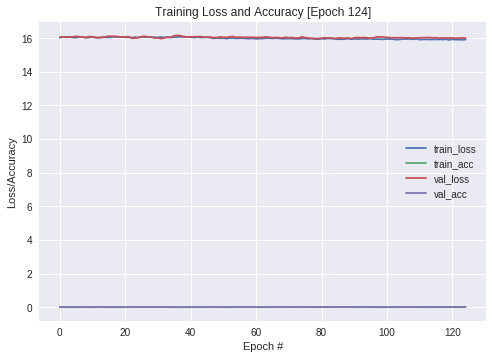

204/204 [==============================] - 90s 442ms/step - loss: 15.9188 - acc: 0.0127 - val_loss: 16.0065 - val_acc: 0.0074


In [37]:
tpu_model.fit_generator(train_generator,
                    steps_per_epoch=num_train_samples/batch_size,
                    validation_data=valid_generator,
                    validation_steps=num_valid_samples/batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    callbacks=[LearningRateScheduler(lr_schedule),plot_losses])